Cuda (GPU support) is not available :(

Etth1 dataset has shape of: (17420, 7)
Train data and futured data has shape of: (7, 112, 100) (7, 112, 10)
Validation data and futured data has shape of: (7, 27, 100) (7, 27, 10)
Test data and futured data has shape of: (7, 34, 100) (7, 34, 10)


Epoch  1 	 Training Loss: 0.964865 	 Validation Loss: 1.013922
		 Validation Loss Decreased (inf --> 1.013922)


Epoch  2 	 Training Loss: 0.960249 	 Validation Loss: 1.013917
		 Validation Loss Decreased (1.013922 --> 1.013917)


Epoch  3 	 Training Loss: 0.902121 	 Validation Loss: 0.807250
		 Validation Loss Decreased (1.013917 --> 0.807250)


Epoch  4 	 Training Loss: 0.645153 	 Validation Loss: 0.590431
		 Validation Loss Decreased (0.807250 --> 0.590431)


Epoch  5 	 Training Loss: 0.548044 	 Validation Loss: 0.557816
		 Validation Loss Decreased (0.590431 --> 0.557816)


Epoch  6 	 Training Loss: 0.503746 	 Validation Loss: 0.468876
		 Validation Loss Decreased (0.557816 --> 0.468876)


Epoch  7 

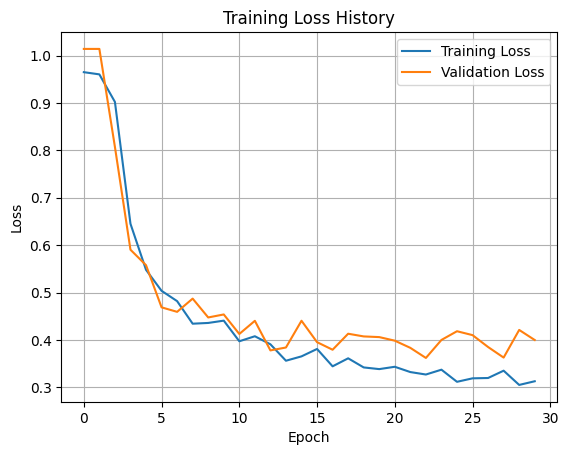

MSE: 0.499836
MAE: 0.545936
Total set number is: 54 
1 Set name: T-3.npy 
Set shape: (2876, 25) [t,D] 
Windowed array shape: (25, 28, 100) [D,i,w] 
Futured array shape: (25, 28, 10) [D,i,zeta] 
One sample mean: 1.3242382001648598e-16 
One sample dimension variance: 1.0
Window length: 100 
Shifting: 100 
Horizon (zeta): 10 
Total set number is: 54 
1 Set name: T-3.npy 
Set shape: (8579, 25) [t,D] 
Windowed array shape: (25, 85, 100) [D,i,w] 
Futured array shape: (25, 85, 10) [D,i,zeta] 
Test means array shape: (25, 85) [D,i] 
Test variance array shape: (25, 85) [D,i]
List length of whole trainDataT: 1344 , and shape of input torch.Size([25, 100]) 
Length of whole futured (targets) list: 1344 , and shape of output torch.Size([25, 10])

List length of whole testSet: 4326 , and shape of input torch.Size([25, 100]) 
Length of whole futured test (targets) list: 4326 , and shape of output torch.Size([25, 10])
Training data and futured:
1076 1076
Validation data and futured:
268 268
Test data 

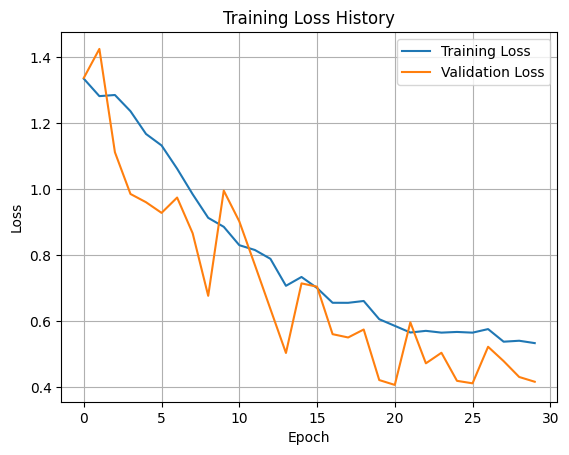

MSE: 0.076146
MAE: 0.078895


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-06-18 23:42:09,230] A new study created in memory with name: no-name-12545e4a-29b8-431c-82cd-67fb7b9080db
C:\Users\User\AppData\Local\Temp\ipykernel_23932\3185298238.py:684: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-2)
[I 2023-06-18 23:42:19,613] Trial 0 finished with value: 5.9676966071128845 and parameters: {'BATCH_SIZE': 128, 'lr': 6.197411370504897e-06, 'input_n_layers': 2, 'cascade_n_layers': 3, 'forecast_n_layers': 4, 'n_units': 121}. Best is trial 0 with value: 5.9676966071128845.
[I 2023-06-1

Best Parameters: {'BATCH_SIZE': 128, 'lr': 0.0010590094310910269, 'input_n_layers': 3, 'cascade_n_layers': 1, 'forecast_n_layers': 3, 'n_units': 56}
Best Validation Loss: 2.138388767838478


In [1]:
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# PyTorch libraries:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

###############################################################################################################
## Writing Functions

def windowed_Set(original_data, window_size, shifting,horizon):
    time_sequence_length, n_dimensions  = original_data.shape
    T = int((time_sequence_length - window_size-horizon) / shifting + 1)

    windowedArray = np.empty((n_dimensions, T, window_size))
    futuredArray  = np.empty((n_dimensions, T, horizon))

    for d in range(n_dimensions):
        for i in range(T):
            start_index = i * shifting
            window       = original_data[start_index : start_index + window_size,d]
            horizon_data = original_data[start_index + window_size : start_index + window_size + horizon,d]
            windowedArray[d, i, :] = window
            futuredArray[d, i, :]  = horizon_data
    return windowedArray, futuredArray

def normalize_data(data_, desired_mean, desired_std):
    """This code turns the input into have the desired mean and variance values. When standard deviation is zero,
       since division will be infinity, it will bypass.
    """
    # Calculate the mean and variance of the original data
    data = data_.copy()
    original_mean = np.mean(data)
    original_std = np.std(data)

    # Subtract the mean from each data point
    data -= original_mean
    # Divide each data point by the square root of the variance
    if original_std != 0:
        data /= original_std
        # Multiply each data point by the desired standard deviation
        data *= desired_std
    # Add the desired mean to each data point
    data += desired_mean
    return data
  
# CALCULATING MSE
def calculate_mse(model_, testloader_):
    mse = 0.0

    with torch.no_grad():
        for data in testloader_:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_(inputs)

            mse += torch.mean((outputs - labels) ** 2).item()

    mse /= len(testloader_)

    return mse

import torch

def calculate_mae(model_, testloader_):
    mae = 0.0

    with torch.no_grad():
        for data in testloader_:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_(inputs)

            mae += torch.mean(torch.abs(outputs - labels)).item()

    mae /= len(testloader_)

    return mae

def find_key(dictionary, value):
    for key, val in dictionary.items():
        for i in range(len(val)):
            if val[i] == value:
                return key
    return None  # Value not found in the dictionary

class MarinaDataset_Etth(Dataset):
    def __init__(self, vec,label):
        self.vec = vec
        self.label = label
    def __len__(self):
        return self.vec.shape[1]
    def __getitem__(self, idx):
        return self.vec[:,idx,:], self.label[:,idx,:]
    
class MarinaDataset_Smap(Dataset):
    def __init__(self, vec,label):
        self.vec = vec
        self.label = label
    def __len__(self):
        return len(self.vec)
    def __getitem__(self, idx):        
        return self.vec[idx], self.label[idx] 

###############################################################################################################
# FORECASTING
# For ETTH Dataset
etth1_FILEPATH = "./etth1/ETTh1.csv"
etth1 = pd.read_csv(etth1_FILEPATH);
etth1.head(5)

def trials_MARINA_Etth1(INPUT_LENGTH,zeta,shift):
  ## Normalization Parameters
  wL = INPUT_LENGTH     # window length
  # Defining intermediate length and alpha before designing the modules

  etthData = np.zeros((len(etth1["HUFL"]),7))
  for i, col in enumerate(etth1):
      if col != 'date':
          etthData[:,i-1] = etth1[col]
  print("\nEtth1 dataset has shape of:", etthData.shape)

  n_sequence, n_features  = etthData.shape
  split_index = int(n_sequence * 0.8)  # 80% for training, 20% for testing

  # Split the data into train and test sets
  train_set = etthData[:split_index, :]
  test_data = etthData[split_index:, :]

  # Normalize train_set
  for D_ in range(n_features):
    train_set[:,D_]   = normalize_data(train_set[:,D_],0,1)

  # Normalize test_set
  for D_ in range(n_features):
    test_data[:,D_]   = normalize_data(test_data[:,D_],0,1)

  windowedTrainSet, futuredTrainSet = windowed_Set(train_set,wL,shift,zeta)
  # print("Windowed array shape:",windowedTrainSet.shape,"[D,i,w]",
  #       "\nFutured array shape:",futuredTrainSet.shape,"[D,i,zeta]")

  windowedTest, futuredTest = windowed_Set(test_data,wL,shift,zeta)
  # print("Windowed array shape:",windowedTest.shape,"[D,i,w]",
  #       "\nFutured array shape:",futuredTest.shape,"[D,i,zeta]")

  # Assuming your data is stored in the variable "windowedTrainSet"

  # Generate random indices for the validation set
  valP = 0.2  # Select 20% of the indices for validation
  val_indices = random.sample(range(windowedTrainSet.shape[1]), int(valP * windowedTrainSet.shape[1]))

  # Split the data into training and validation sets
  windowedTrain = np.delete(windowedTrainSet, val_indices, axis=1)
  futuredTrain  = np.delete(futuredTrainSet, val_indices, axis=1)
  windowedVal   = windowedTrainSet[:, val_indices, :]
  futuredVal    = futuredTrainSet[:, val_indices, :]

  # Verify the shapes of the train and validation sets
  print("Train data and futured data has shape of:",windowedTrain.shape, futuredTrain.shape)
  print("Validation data and futured data has shape of:",windowedVal.shape, futuredVal.shape)
  print("Test data and futured data has shape of:",windowedTest.shape, futuredTest.shape)

  return windowedTrain,futuredTrain,windowedVal,futuredVal,windowedTest,futuredTest

###############################################################################################################
# Choosing the parameters for the model. In the paper Input length is 100 and zeta changes. Shifting is something
# that we added in order to ease the performance. 

INTERMEDIATE_LENGTH = 24
INPUT_LENGTH        = 100
zeta                = 10
shifting            = INPUT_LENGTH
windowedTrain,futuredTrain,windowedVal,futuredVal,windowedTest,futuredTest = trials_MARINA_Etth1(INPUT_LENGTH,zeta,shifting)

###############################################################################################################
# CREATE the MODEL
# We created the model parametric in hence we will need to optimize the hyperparameters later.

class InputSubBlock(nn.Module):
    def __init__(self, n_layers, n_units):
        super(InputSubBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(INPUT_LENGTH, n_units))  # First layer

        for _ in range(n_layers - 1):  # Add remaining layers
            self.layers.append(nn.Linear(n_units, n_units))

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

class CascadeSubBlock(nn.Module):
    def __init__(self, n_layers, n_units):
        super(CascadeSubBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(n_units, n_units))  # First layer

        for _ in range(n_layers - 1):  # Add remaining layers
            self.layers.append(nn.Linear(n_units, n_units))

        self.fc2 = nn.Linear(n_units, INPUT_LENGTH)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = F.relu(self.fc2(x))
        return x

class ForecastingSubBlock(nn.Module):
    def __init__(self, n_layers, n_units):
        super(ForecastingSubBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(n_units, n_units))  # First layer

        for _ in range(n_layers - 1):  # Add remaining layers
            self.layers.append(nn.Linear(n_units, n_units))

        self.fc2 = nn.Linear(n_units, INTERMEDIATE_LENGTH)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = F.relu(self.fc2(x))
        return x

class MLPBlock(nn.Module):

    def __init__(self,input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units):
        super(MLPBlock, self).__init__()
        self.input = InputSubBlock(input_n_layers,input_n_units)
        self.cascade = CascadeSubBlock(cascade_n_layers,cascade_n_units)
        self.forecasting = ForecastingSubBlock(forecast_n_layers,forecast_n_units)

    def forward(self, x):
        #print("1",x.shape)
        x = self.input(x)
        #print("2s",x.shape)
        cascade = self.cascade(x)

        forecast = self.forecasting(x)

        return cascade , forecast
class TemporalModule(nn.Module):
    def __init__(self,input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units):
        super(TemporalModule, self).__init__()
        self.mlp1 = MLPBlock(input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units)
        self.mlp2 = MLPBlock(input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units)

    def forward(self, input):
        mlp1_out , forecast = self.mlp1(input)
        new_input = mlp1_out - input
        mlp2_out , forecast_2 = self.mlp2(new_input)
        return (forecast + forecast_2)

class SpatialModule(nn.Module):
    def __init__(self, n_layers, n_units):
        super(SpatialModule, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=INTERMEDIATE_LENGTH, num_heads=8, dropout=0.05)
        self.feed_forward = nn.Sequential(
            nn.Linear(INTERMEDIATE_LENGTH, n_units),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(n_units, INTERMEDIATE_LENGTH)
        )

    def forward(self, x):
        x, _ = self.self_attention(x, x, x)
        x = self.feed_forward(x)
        return x

class OutputModule(nn.Module):
    def __init__(self):
        super(OutputModule, self).__init__()
        self.FFN = nn.Linear(INTERMEDIATE_LENGTH,zeta)
    def forward(self, x):
        x = self.FFN(x)
        return x

class modeMARINA(nn.Module):
    def __init__(self, input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units, spatial_n_layers, spatial_n_units):
        super(modeMARINA, self).__init__()
        self.temporal = TemporalModule(input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units)
        self.spatial = SpatialModule(spatial_n_layers, spatial_n_units)
        self.output = OutputModule()

    def forward(self, x):
        x = self.temporal(x)
        x = self.spatial(x)
        x = self.output(x)
        return x

windowedTrainT = torch.tensor(windowedTrain).float()
futuredTrainT  = torch.tensor(futuredTrain).float()
windowedValT   = torch.tensor(windowedVal).float()
futuredValT    = torch.tensor(futuredVal).float()
windowedTestT  = torch.tensor(windowedTest).float()
futuredTestT   = torch.tensor(futuredTest).float()

###############################################################################################################
# Training params and data loaders
BATCH_SIZE          = 5       

trainset            = MarinaDataset_Etth(windowedTrainT,futuredTrainT)
trainloader1         = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)

validset            = MarinaDataset_Etth(windowedValT,futuredValT)
validloader1         = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)

testset             = MarinaDataset_Etth(windowedTestT,futuredTestT)
testloader1          = torch.utils.data.DataLoader(testset, batch_size=1)

###############################################################################################################
# FORECASTING HYPERPARAMETERS
n_units        = 200

input_n_layers = 2  # Number of layers in InputSubBlock
input_n_units = n_units  # Number of units in each layer of InputSubBlock

cascade_n_layers = 2  # Number of layers in CascadeSubBlock
cascade_n_units = n_units  # Number of units in each layer of CascadeSubBlock

forecast_n_layers = 1  # Number of layers in ForecastingSubBlock
forecast_n_units = n_units  # Number of units in each layer of ForecastingSubBlock

spatial_n_layers = 1  # Number of layers in SpatialModule
spatial_n_units = n_units  # Number of units in each layer of SpatialModule

model_forecast = modeMARINA(input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units, spatial_n_layers, spatial_n_units)

###############################################################################################################
# TRAIN THE MODEL FOR FORECASTING

model_forecast  = model_forecast.to(device)
lr              = 0.0002
criterion       = nn.MSELoss()
optimizer       = optim.Adam(model_forecast.parameters(), lr=lr)  # Add weight decay parameter

def train_model(model,criterion,optimizer,trainloader,validloader):
    min_valid_loss  = np.inf
    epoch           = 30       # From the figure 7 in the paper.
    loss_history    = []
    valid_loss_history = []

    start_time = time.time() # Setting starting point for finding the execution time

    for epoch in range(epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        model.train()

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(validloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                outputs = outputs.to(device)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        loss_history.append(running_loss / len(trainloader))
        valid_loss_history.append(valid_loss /len(validloader))
        print(f'\n\nEpoch {epoch+1:2d} \t Training Loss: {running_loss / len(trainloader):.6f} \t Validation Loss: {valid_loss / len(validloader):.6f}')

        if min_valid_loss > valid_loss:
            print(f'\t\t Validation Loss Decreased ({min_valid_loss/len(validloader):.6f} --> {valid_loss/len(validloader):.6f})')
            min_valid_loss = valid_loss
            # Saving State Dict
            # torch.save(model.state_dict(),'saved_model.pth')

    print('Finished Training')

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Total Execution Time: {execution_time:.2f} seconds")

    # Plotting the loss history
    plt.plot(loss_history, label='Training Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.grid(True)
    plt.legend()  # Add legend
    plt.show()
    return

train_model(model_forecast,criterion,optimizer,trainloader1,validloader1)

# CALCULATE THE MSE 
model_forecast.eval()
mse_score = calculate_mse(model_forecast, testloader1)
print(f"MSE: {mse_score:.6f}")

# CALCULATE THE MAE 
mae_score = calculate_mae(model_forecast, testloader1)
print(f"MAE: {mae_score:.6f}")


###############################################################################################################
# ANOMALY DETECTION
# For SMAP Dataset
LABELS_FILEPATH = "./SMAP MSL/labeled_anomalies.csv"
TRAINSET_FILEPATH = "./SMAP MSL/data/data/train"
TESTSET_FILEPATH = "./SMAP MSL/data/data/test"

labels = pd.read_csv(LABELS_FILEPATH)
labels.head(5)

###############################################################################################################
# Data loading 
# T-10 data is not in Labels but in Train Dataset. Therefore, T-10 will not be used for now.
import os
train_datas = {}
test_datas = {}
arranged_train_datas = {}
arranged_test_datas = {}

desiredSC      = 'SMAP'
# Iterate directory
for path in os.listdir(TRAINSET_FILEPATH):
    # check if current path is a file
    if os.path.isfile(os.path.join(TRAINSET_FILEPATH, path)):
        if path != 'T-10.npy':
            SC_labels     = labels[labels['chan_id'] == path.replace('.npy','')]
            SC            = SC_labels['spacecraft']
            # print("SC_labels",SC_labels)
            # print("SC",SC)
            # print((SC.iloc[0]),path.replace('.npy',''))
            SC_name       = SC.iloc[0]
            if SC_name == desiredSC:
                train_data = np.load(os.path.join(TRAINSET_FILEPATH, path))
                train_datas[path] = train_data

for path in os.listdir(TESTSET_FILEPATH):
    # check if current path is a file
    if os.path.isfile(os.path.join(TESTSET_FILEPATH, path)):
        if path != 'T-10.npy':
            SC_labels     = labels[labels['chan_id'] == path.replace('.npy','')]
            SC            = SC_labels['spacecraft']
            SC_name       = SC.iloc[0]
            if SC_name == desiredSC:       
                test_data = np.load(os.path.join(TESTSET_FILEPATH, path))
                test_datas[path] = test_data

###############################################################################################################
#4.1 data normalization 
#1 - training normalization 
wL                          = INPUT_LENGTH     # window length
shift                       = shifting
ALPHA                       = 0.1

train_means = {}
train_variances = {}
windowedTrain = {}      # Dividing the data with windows
futuredTrain = {}       # Creating arrays to be futured

for train_data in train_datas:
    #print(train_datas[train_data].shape)
    D                                       = train_datas[train_data].shape[1]
    iN                                      = train_datas[train_data].shape[0]

    for D_ in range(D):
        train_datas[train_data][:,D_]       = normalize_data(train_datas[train_data][:,D_],0,1)
    #train_datas[train_data] = train_datas[train_data] * 2 - 1  # variance 1 olacak teyit et
    
    windowedTrain[train_data], futuredTrain[train_data] = windowed_Set(train_datas[train_data],wL,shift,zeta)

print("Total set number is:",len(windowedTrain),
      "\n1 Set name:",train_data,
      "\nSet shape:",train_datas[train_data].shape,"[t,D]",
      "\nWindowed array shape:",windowedTrain[train_data].shape,"[D,i,w]",
      "\nFutured array shape:",futuredTrain[train_data].shape,"[D,i,zeta]",
      "\nOne sample mean:", np.mean(train_datas[train_data]),
      "\nOne sample dimension variance:", np.std(train_datas[train_data][:,0]))
      
windowedTest    = {}
futuredTest     = {}
test_means      = {}
test_variances  = {}
test_std        = {}

for test_data in test_datas:
    windowedTest[test_data], futuredTest[test_data] = windowed_Set(test_datas[test_data],wL,shift,zeta)

for test_data in test_datas:
    #print(test_datas[test_data].shape)
    D                               = windowedTest[test_data].shape[0]
    iN                              = windowedTest[test_data].shape[1]

    test_means[test_data]           = np.zeros((D,iN))
    test_variances[test_data]       = np.zeros((D,iN))
    test_std[test_data]             = np.zeros((D,iN))
    test_means[test_data][:,0]      = 0
    test_std[test_data][:,0]        = 0
    test_variances[test_data][:,0]  = 1 

    for iN_ in range(1,iN): 
        E                                = np.mean(windowedTest[test_data][:,iN_,:],axis = 1)
        E2                               = np.mean(windowedTest[test_data][:,iN_,:]**2,axis = 1)    
        test_means[test_data][:,iN_]     = (1-ALPHA)*test_means[test_data][:,iN_-1] + ALPHA*E 
        test_variances[test_data][:,iN_] = (1-ALPHA)*test_variances[test_data][:,iN_-1]+ALPHA*(E2-E**2)
        test_std[test_data][:,iN_]       = np.sqrt(test_variances[test_data][:,iN_-1])
        for D_ in range(D):
            dynamicMean                       = test_means[test_data][D_,iN_-1]
            dynamicVar                        = test_variances[test_data][D_,iN_-1]
            dynamicStd                        = test_std[test_data][D_,iN_-1]
            
            windowedTest[test_data][D_,iN_,:] = normalize_data(windowedTest[test_data][D_,iN_,:],dynamicMean,dynamicStd)

print("Window length:", wL,
      "\nShifting:",shift,
      "\nHorizon (zeta):",zeta,
      "\nTotal set number is:",len(windowedTest),
      "\n1 Set name:",test_data,
      "\nSet shape:",test_datas[test_data].shape,"[t,D]",
      "\nWindowed array shape:",windowedTest[test_data].shape,"[D,i,w]",
      "\nFutured array shape:",futuredTest[test_data].shape,"[D,i,zeta]",
      "\nTest means array shape:",test_means[test_data].shape,"[D,i]",
      "\nTest variance array shape:",test_variances[test_data].shape,"[D,i]")


# Stacking all data
alltrainDataT      = []    # Create a list for training data
allfuturedTrainT   = []    
testSet          = []  
test_futured       = [] 

testSetIdx         = []
for i,name in enumerate(windowedTrain.keys()):
    for j in range(windowedTrain[name].shape[1]):                                 # Looping over T dimension for stacking                              
        alltrainDataT.append(torch.tensor(windowedTrain[name][:,0,:]).float())   # Swapping the dimensions accordingly as (T,D,W).
        allfuturedTrainT.append(torch.tensor(futuredTrain[name][:,0,:]).float()) # Swapping the dimensions accordingly as (T,D,W).
      
for i,name in enumerate(windowedTest.keys()):
    for j in range(windowedTest[name].shape[1]):                                 # Looping over T dimension for stacking                              
        testSet.append(torch.tensor(windowedTest[name][:,0,:]).float())   # Swapping the dimensions accordingly as (T,D,W).
        test_futured.append(torch.tensor(futuredTest[name][:,0,:]).float()) # Swapping the dimensions accordingly as (T,D,W).
        testSetIdx.append([name, wL + zeta + shift*j - 1])

    #print(windowedTrain[name].shape)
print("List length of whole trainDataT:",len(alltrainDataT),", and shape of input",alltrainDataT[1].shape,
      "\nLength of whole futured (targets) list:",len(allfuturedTrainT),", and shape of output",allfuturedTrainT[1].shape)
print("\nList length of whole testSet:",len(testSet),", and shape of input",testSet[1].shape,
      "\nLength of whole futured test (targets) list:",len(test_futured),", and shape of output",test_futured[1].shape)


# Generate random indices for the validation set
valP            = 0.2 # Select 20% of the indices for validation
val_indices = random.sample(range(len(alltrainDataT)), k=int(len(alltrainDataT) * valP))  
# Split the data into training and validation sets
trainSet, validSet, train_futured, val_futured = [], [], [], []
for i in range(len(alltrainDataT)):
    if i in val_indices:
        validSet.append(alltrainDataT[i])
        val_futured.append(allfuturedTrainT[i])
    else:
        trainSet.append(alltrainDataT[i])
        train_futured.append(allfuturedTrainT[i])

print("Training data and futured:")
print(len(trainSet),len(train_futured))
print("Validation data and futured:")
print(len(validSet),len(val_futured))
print("Test data and futured:")
print(len(testSet),len(test_futured))

# Training params
BATCH_SIZE                  = 128
lr                          = 0.005

trainset            = MarinaDataset_Smap(trainSet,train_futured)
trainloader2        = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)      
 
validset            = MarinaDataset_Smap(validSet,val_futured)
validloader2        = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)

testset            = MarinaDataset_Smap(testSet,test_futured)
testloader2        = torch.utils.data.DataLoader(testset, batch_size=1)


###############################################################################################################
# ANOMALY HYPERPARAMETERS
n_units        = 50

input_n_layers = 3  # Number of layers in InputSubBlock
input_n_units = n_units  # Number of units in each layer of InputSubBlock

cascade_n_layers = 2  # Number of layers in CascadeSubBlock
cascade_n_units = n_units  # Number of units in each layer of CascadeSubBlock

forecast_n_layers = 2  # Number of layers in ForecastingSubBlock
forecast_n_units = n_units  # Number of units in each layer of ForecastingSubBlock

spatial_n_layers = 1  # Number of layers in SpatialModule
spatial_n_units = n_units  # Number of units in each layer of SpatialModule

model_Anomaly = modeMARINA(input_n_layers, input_n_units, cascade_n_layers, cascade_n_units, forecast_n_layers, forecast_n_units, spatial_n_layers, spatial_n_units)

###############################################################################################################
# TRAINING MODEL FOR ANOMALY DETECTION

criterion       = nn.MSELoss()
optimizer       = optim.Adam(model_Anomaly.parameters(), lr=lr)

train_model(model_Anomaly,criterion,optimizer,trainloader2,validloader2)

# CALCULATE THE MSE 
model_Anomaly.eval()
mse_score = calculate_mse(model_Anomaly, testloader2)
print(f"MSE: {mse_score:.6f}")

# CALCULATE THE MAE 
mae_score = calculate_mae(model_Anomaly, testloader2)
print(f"MAE: {mae_score:.6f}")





anomalies = {}
i = 0
ii = 0
threshold = 0.85
with torch.no_grad():
    for data in testloader2:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_Anomaly(inputs)
            #compare output with labels using frobenius norm
            frob_error  =  torch.sqrt(torch.abs(torch.sum(outputs ** 2 - labels ** 2)))
            #this if else is for catching the beginning and end of the sequences
            if( frob_error > threshold ):
                [keyN, valueN] =  testSetIdx[ii]
                if keyN not in anomalies:
                    anomalies[keyN] = []
                anomalies[keyN].append(valueN)
            ii += 1                                


###############################################################################################################
# OPTIMIZE THE HYPERPARAMETERS WITH OPTUNA

import optuna

def objective(trial,trainloader_,valid_loader_):
    # Define the hyperparameters to optimize
    BATCH_SIZE = trial.suggest_categorical('BATCH_SIZE', [64, 128])  # Remove the third argument

    lr = trial.suggest_loguniform('lr', 1e-6, 1e-2)

    input_n_layers1 = trial.suggest_int('input_n_layers', 2, 4)  # Remove the third argument
    cascade_n_layers1 = trial.suggest_int('cascade_n_layers', 1, 3)  # Remove the third argument
    forecast_n_layers1 = trial.suggest_int('forecast_n_layers', 2, 4)  # Remove the third argument
    n_units = trial.suggest_int('n_units', 50, 200)  # Remove the third argument


    # Update the hyperparameters in your model
    model = modeMARINA(input_n_layers=input_n_layers1, input_n_units=n_units,
                       cascade_n_layers=cascade_n_layers1, cascade_n_units=n_units,
                       forecast_n_layers=forecast_n_layers1, forecast_n_units=n_units,
                       spatial_n_layers=1, spatial_n_units=n_units)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    min_valid_loss = np.inf
    epoch = 30
    loss_history = []

    for epoch in range(epoch):
        running_loss = 0.0
        model.train()

        for i, data in enumerate(trainloader_, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_loader_, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                outputs = outputs.to(device)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        loss_history.append(running_loss / len(trainloader_))
        #print(f'Epoch {epoch+1:2d} \t Training Loss: {running_loss / len(trainloader):.6f} \t Validation Loss: {valid_loss / len(validloader):.6f}')

        if min_valid_loss > valid_loss:
            #print(f'\t\t Validation Loss Decreased ({min_valid_loss/len(validloader):.6f} --> {valid_loss/len(validloader):.6f})')
            min_valid_loss = valid_loss

    return min_valid_loss

# Define the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, trainloader1, validloader1), n_trials=5)

# Print the best hyperparameters and the best validation loss
best_params = study.best_params
best_loss = study.best_value
print('Best Parameters:', best_params)
print('Best Validation Loss:', best_loss)